In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.linear_model import LassoCV

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

**Часть 1. Предобработка данных**

1.	Загрузка и изучение данных. 

In [2]:
data = pd.read_excel('Online Retail.xlsx')
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


2.	Очистка данных: удаление дубликатов, обработка пропущенных значений и выбросов. 

In [3]:
data = data.dropna()

3.	Преобразование категориальных признаков с использованием one-hot encoding или других подходов. 

In [4]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

data = data.sort_values(by = ['CustomerID'])
data = data.loc[data['Quantity']>=0] 
max_date = data.groupby(['CustomerID']).agg({"InvoiceDate":"max"})
data = data.join(max_date,on="CustomerID", rsuffix = "Max")
data['MaxDate'] = data['InvoiceDateMax'].max()
data['time_from_last_Invoice'] =round((data['MaxDate']- data['InvoiceDateMax']) / np.timedelta64(1, 'D'),0)
data['Client_is_gone'] = data['time_from_last_Invoice'].apply(lambda x :0 if x < 90 else 1)
data = data.drop("time_from_last_Invoice", axis = 1)

categorical_columns = [c for c in data.columns if data[c].dtype.name =='object']
numerical_columns = data.mode(numeric_only=True).columns.values.tolist()

print(categorical_columns)
print(numerical_columns)

data_nonbinary = pd.get_dummies(data['Country'])
data_nonbinary = data_nonbinary.drop('Unspecified', axis = 1)

data_numerical = data[numerical_columns]
data_numerical = (data_numerical - data_numerical.mean())/data_numerical.std()

data = data.drop('MaxDate', axis = 1)
data = data.drop('InvoiceNo', axis = 1)
data = data.drop('StockCode', axis = 1)
data = data.drop('Description', axis = 1)
data = data.drop('InvoiceDate', axis = 1)
data = data.drop('InvoiceDateMax', axis = 1)
data_numerical = data_numerical.drop('Client_is_gone', axis = 1)

data2 = pd.concat((data_numerical, data_nonbinary), axis = 1)

<ipython-input-4-990c7ded27b9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])


['InvoiceNo', 'StockCode', 'Description', 'Country']
['Quantity', 'UnitPrice', 'CustomerID', 'Client_is_gone']


4.	Разделение данных на обучающую и тестовую выборки.

In [5]:
X = data2
y = data['Client_is_gone']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
data2

,Quantity,UnitPrice,CustomerID,Australia,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,...,Portugal,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom
61619,411.273095,-0.093958,-1.720971,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
286628,-0.038919,-0.039199,-1.720387,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72263,-0.016749,-0.084455,-1.720387,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72264,-0.016749,-0.084455,-1.720387,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72265,-0.038919,-0.007520,-1.720387,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392737,0.127359,-0.075403,1.746870,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
392736,0.193871,-0.103462,1.746870,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
392735,0.060848,-0.123374,1.746870,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
423939,0.127359,-0.084455,1.746870,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


**Часть 2. Обучение базовой модели.**

1.	Обучение логистической регрессии на обучающей выборке. 

In [6]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

2. Предсказание на тестовой выборке

In [7]:
y_pred = log_reg.predict(X_test)

3.	Оценка качества модели на тестовой выборке с использованием различных метрик (accuracy, precision, recall, F1-score, AUC-ROC). 

In [8]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred))

Accuracy: 0.8788967770308476
Precision: 0.8902439024390244
Recall: 0.014949825926684415
F1-score: 0.029405840886203426
AUC-ROC: 0.5073460082239446


**Часть 3. Исследование различных техник оптимизации.**

Обучение LASSO-регрессии с кросс-валидацией

In [9]:
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.938e+00, tolerance: 3.399e+00
  model = cd_fast.enet_coordinate_descent(


LassoCV(cv=5, random_state=42)

Определение коэффициентов LASSO-регрессии

In [10]:
coef = lasso.coef_

Отбор важных признаков

In [11]:
important_features = [feature for feature, coef in zip(X_train.columns, coef) if abs(coef) > 0]

Фильтрация данных с использованием отобранных признаков

In [12]:
X_train_filtered = X_train[important_features]
X_test_filtered = X_test[important_features]

**Часть 4. Выбор метрики качества.**

1.	Обоснование выбора метрики качества для данной задачи (с учетом специфики проблемы оттока клиентов). 

In [13]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_filtered, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

Предсказание на тестовой выборке

In [14]:
y_pred = log_reg.predict(X_test_filtered)

2.	Оценка качества оптимизированной модели с использованием выбранной метрики.

In [15]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred))

Accuracy: 0.8788967770308476
Precision: 0.8902439024390244
Recall: 0.014949825926684415
F1-score: 0.029405840886203426
AUC-ROC: 0.5073460082239446


Влияние признаков на отток клиентов

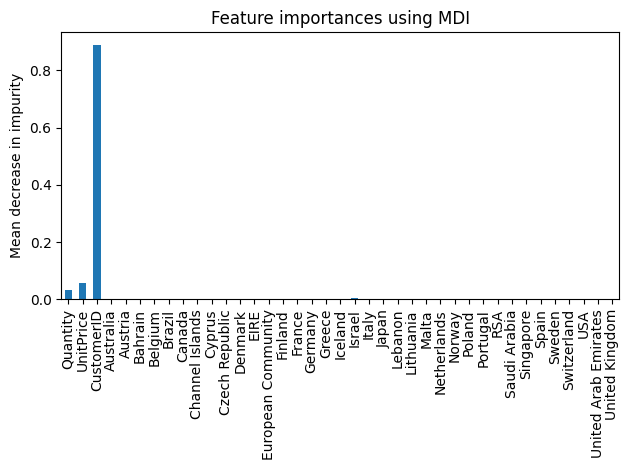

In [16]:
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)
importances = model.feature_importances_
feature_names = X_train.columns
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()